# k-Means Clustering

This notebook uses sample data to demonstrate the k-Means clustering algorithm by building the model from scratch.

The cluster centers can either all be initialized randomly using <b>get_initial_centroids</b> or the first of k cluster centers can be randomly initialized with <b>get_initial_centroid</b> and all remaining centroids will be selected using farthest search.

In [1]:
# import libraries
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# settings
seed = 1234
np.random.seed(seed)

In [3]:
# load data
data = np.load('AllSamples.npy')

In [4]:
# define functions to initialize k cluster centroids
def get_initial_centroids(data, k):
    N = data.shape[0]
    initial_indices = np.random.RandomState(seed=seed).permutation(N)[:k]
    initial_centers = data[initial_indices,:]
    
    return initial_centers

In [5]:
# define function to initialize first of k cluster centroids
def get_initial_centroid(data, k):
    N = data.shape[0]
    initial_index = np.random.RandomState(seed=seed).permutation(N)[0]
    initial_center = data[initial_index,:]
    
    return initial_center

In [6]:
# get initial points for a defined k
k = 5
initial_centroids = get_initial_centroids(data, k)

In [7]:
# preview
print('K = {}'.format(k))
print('Initial Centroids:\n{}'.format(initial_centroids))

K = 5
Initial Centroids:
[[7.77126987 8.91428052]
 [2.23518365 3.77218252]
 [2.69511302 5.93967352]
 [5.60944242 2.91327032]
 [3.40504475 1.04980673]]


In [8]:
# create k-Means functions
class kMeans:
    def __init__(self, data, k, centroids, initialize):
        """Initializes the k-means model"""
        self.data = data           # 2D data array
        self.k = k                 # number of clusters
        self.distances = {}        # distance of each point to each cluster center
        self.clusters = {}         # dict of point lists for each cluster association
        self.cost = 0              # total cost (i.e. inertia) to measure 'loss'
        self.init = initialize     # boolean indicating whether centroids need to be initialized
        
        if initialize:
            # initialize using farthest search
            self.centroids = self.farthest_search(centroids)
        else:
            # initialized cluster centers
            self.centroids = centroids
    
    # Farthest search
    def farthest_search(self, centroid):
        """
        Scan the list of not-yet-selected points to find a point p
        that has the maximum distance from the selected points.
        Remove p from the not-yet-selected points and add it to the
        end of the sequence of selected points.
        For each remaining not-yet-selected point q, replace the
        distance stored for q by the minimum of its old value
        and the distance from p to q.
        """
        # initialize points as list so we can remove used centroids
        temp = copy.deepcopy(self.data)
        points = temp.tolist()
        
        # initialize centroid results
        results = []
        
        # add the first centroid to the results
        index = np.where(points == centroid)[0][0]
        results.append(points.pop(index))

        # iterate over k-1 remaining centroids
        for _ in range(1,self.k):
            # compute the distances from the points to the centroid
            distances = [self.compute_distance(p, results[0]) for p in points]
            
            # iterate over the remaining points
            for i, p in enumerate(points):
                
                # iterate over the centroids
                for j, q in enumerate(results):
                    
                    # replace distance by the minimum of its old value and distance from p to q
                    distances[i] = min(distances[i], self.compute_distance(p, q))

            # get the furthest point
            index = distances.index(max(distances))
            value = points.pop(index)
            
            # add to the list of centroids
            results.append(value)

        return np.array(results)
    
    def compute_distance(self, a, b):
        """Compute the distance between two points."""
        dist = abs(a[0] - b[0]) + abs(a[1] - b[1])
        return dist
    
    def compute_distances(self):
        """Computes the Euclidean distance between each data point and each cluster centroid"""
        self.distances = {}
        for i in range(self.k):
            centroid = self.centroids[i,:]
            self.distances[i] = [np.linalg.norm(point - centroid) for point in self.data]
    
    def assign_to_cluster(self):
        """Assigns each point to the closest centroid"""
        self.clusters = {}
        n = self.data.shape[0]
        
        for a in range(self.k):
            self.clusters[a] = []
            
        for b in range(n):
            temp = [self.distances[x][b] for x in self.distances.keys()]
            cluster_center, data_point = np.argmin(temp), self.data[b]
            self.clusters[cluster_center].append(data_point)
        
        for c in range(self.k):
            self.clusters[c] = np.array(self.clusters[c])
    
    def visualize_data(self):
        """Plots the data with its respective centroids"""
        fig, ax = plt.subplots(1, 1)
        
        for k in self.clusters.keys():
            data = self.clusters[k]
            x, y = data[:,0], data[:,1]
            
            centroid = self.centroids[k]
            xc, yc = centroid[0], centroid[1]
            
            plt.scatter(x, y)
            plt.scatter(xc, yc, c='black', s=150, marker='x', linewidth=5)
            
        plt.show()
    
    def compute_cluster_centers(self):
        """Computes new cluster centers for each group based on average distance"""
        new_centroids = []
        for k in self.clusters.keys():
            data = self.clusters[k]
            new_centroids.append(np.mean(data, axis=0))
            
        self.centroids = np.array(new_centroids)
        
    def compute_cost(self):
        """Computes the inertia (i.e. loss) for the current solution"""
        total_cost = 0
        for k in self.clusters.keys():
            centroid = self.centroids[k]
            data = self.clusters[k]
            centroid_cost = np.sum([(point - centroid)**2 for point in data])
            total_cost += centroid_cost
            
        self.cost = total_cost
        
    def run_solver(self):
        """Iterates until the solver converges and the cluster centers no longer update"""
        keep_going = True
        while keep_going:
            old_centroids = self.centroids
            self.compute_distances()
            self.assign_to_cluster()
            self.visualize_data()
            self.compute_cluster_centers()
            
            if np.array_equal(old_centroids, self.centroids):
                keep_going = False
                
                for k in range(self.k):
                    print('Cluster {} centroid: {}'.format(k+1, self.centroids[k]))
                    
                self.compute_cost()
                print('Total inertia: {}'.format(self.cost))

In [9]:
# initialize instance with k=5, data, and initialized centroids
my_kMeans = kMeans(data, k, initial_centroids, False)

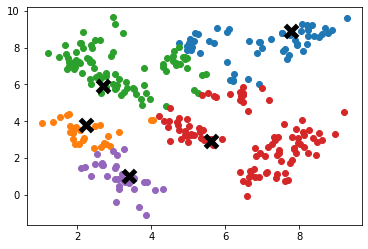

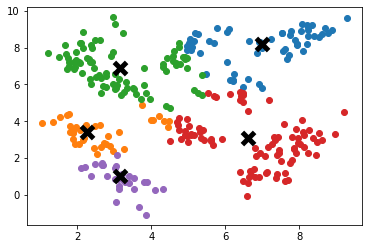

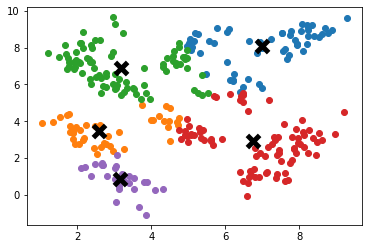

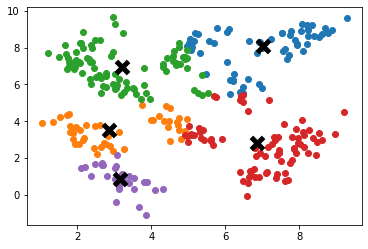

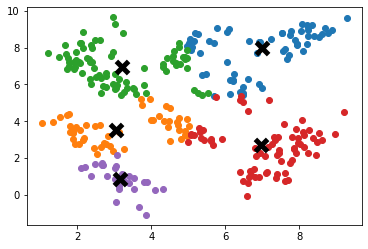

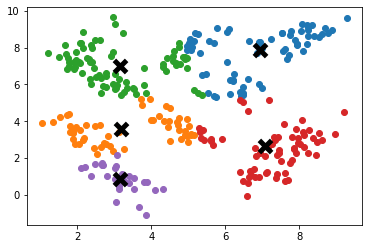

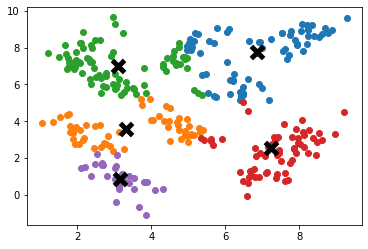

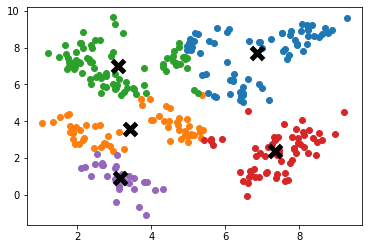

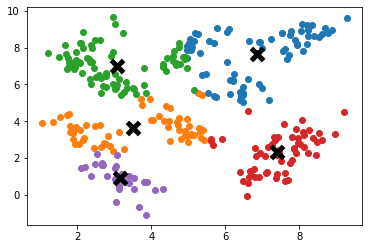

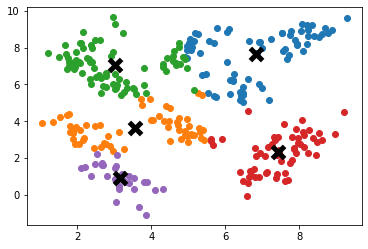

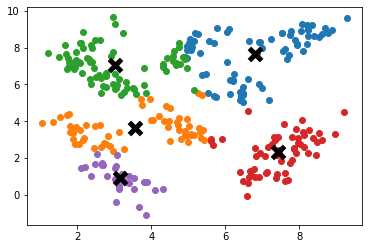

Cluster 1 centroid: [6.80421029 7.6562222 ]
Cluster 2 centroid: [3.5545081  3.62813062]
Cluster 3 centroid: [3.006688   7.03481503]
Cluster 4 centroid: [7.41419243 2.32169114]
Cluster 5 centroid: [3.14506148 0.90770655]
Total inertia: 653.9567908403941


In [10]:
# run unsupervised learning algorithm
my_kMeans.run_solver()

In [11]:
# get initial points for a defined k using farthest search
k = 5
initial_centroid = get_initial_centroid(data, k)

In [12]:
# preview
print('K = {}'.format(k))
print('Initial Centroid:\n{}'.format(initial_centroid))

K = 5
Initial Centroid:
[7.77126987 8.91428052]


In [13]:
# initialize instance with k=5, data, and have the class initialize the k-1 remaining centroids
my_kMeans = kMeans(data, k, initial_centroid, True)

In [14]:
# verify that k-1 centroids initialized correctly
my_kMeans.centroids

array([[ 7.77126987,  8.91428052],
       [ 3.04101702, -0.36138487],
       [ 1.72614408,  6.81819407],
       [ 8.44178587,  2.18453296],
       [ 4.75184863,  4.20214023]])

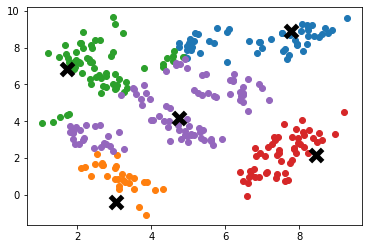

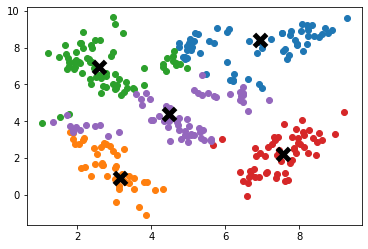

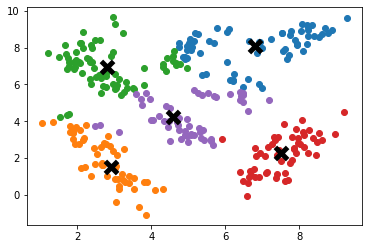

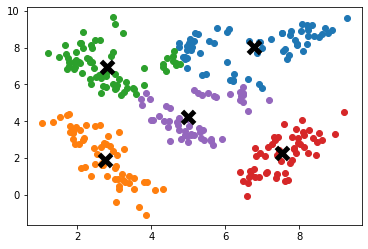

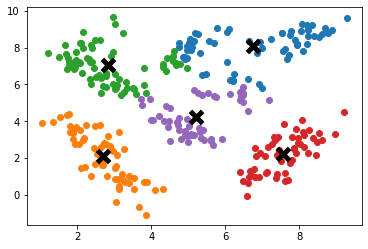

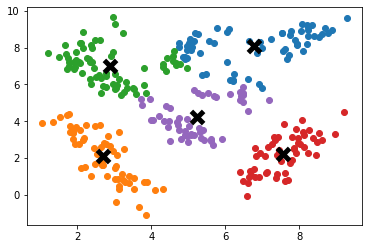

Cluster 1 centroid: [6.7786424  8.07967641]
Cluster 2 centroid: [2.68198633 2.09461587]
Cluster 3 centroid: [2.87490813 7.01082281]
Cluster 4 centroid: [7.55616782 2.23516796]
Cluster 5 centroid: [5.22321274 4.22502829]
Total inertia: 598.5546443663115


In [15]:
# run unsupervised learning algorithm
my_kMeans.run_solver()